In [7]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
from torch.autograd import Variable

In [57]:
train, val, test, data = (np.load("../data/task1_%s.npz" % f)
                    for f in ("train", "val", "test", "data"))
xtr, ytr, xval, yval, xte, yte, xdata, ydata = (
  torch.from_numpy(arr).float()
  for arr in (train["x"], train["y"], val["x"], val["y"], test["x"], test["y"], data["x"], data["y"])
)

In [58]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 7

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [59]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

x = xtr[0]
x = x[..., None]
y = ytr[0]
y = y[...,None]

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 958.39307
Epoch: 100, loss: 814.20697
Epoch: 200, loss: 622.63708
Epoch: 300, loss: 485.30139
Epoch: 400, loss: 388.54895
Epoch: 500, loss: 315.23431
Epoch: 600, loss: 259.42621
Epoch: 700, loss: 217.40140
Epoch: 800, loss: 186.29581
Epoch: 900, loss: 161.78006
Epoch: 1000, loss: 141.04164
Epoch: 1100, loss: 126.71498
Epoch: 1200, loss: 116.31934
Epoch: 1300, loss: 107.80276
Epoch: 1400, loss: 101.25797
Epoch: 1500, loss: 96.77421
Epoch: 1600, loss: 93.42537
Epoch: 1700, loss: 90.83798
Epoch: 1800, loss: 88.74742
Epoch: 1900, loss: 85.34017


287


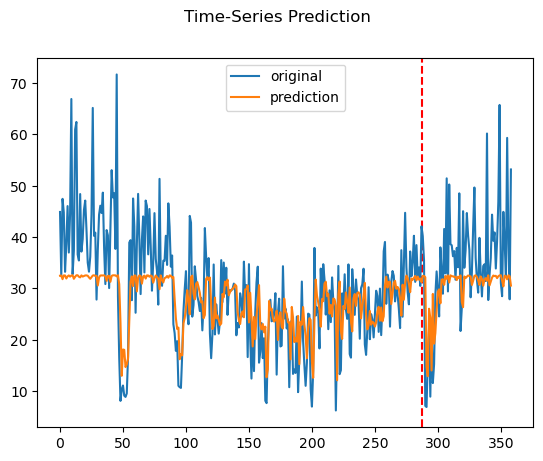

In [64]:
lstm.eval()
xd= xdata[0][...,None]
train_predict = lstm(xd)

data_predict = train_predict.data.numpy()
dataY_plot = ydata[0].data.numpy()

training_length = int(len(xd)*0.8)
print(training_length)
plt.axvline(x=training_length, c='r', linestyle='--')

plt.plot(dataY_plot, label="original")
plt.plot(data_predict, label="prediction")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()